In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.2 MB/s eta 0:00:00


# Audio to Lyrics generator

## Wave2Vec2

In [ ]:
import librosa
import torch
from IPython.display import Audio
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Loading the audio file
audio, rate = librosa.load("/content/rock.00000.wav", sr = 16000)

Text(0.5, 1.0, 'Audio Waveform')

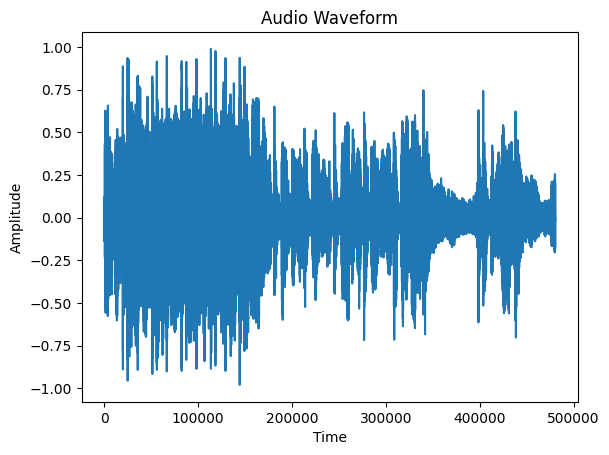

In [ ]:
plt.plot(audio)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Audio Waveform")

Text(0.5, 1.0, 'Spectogram')

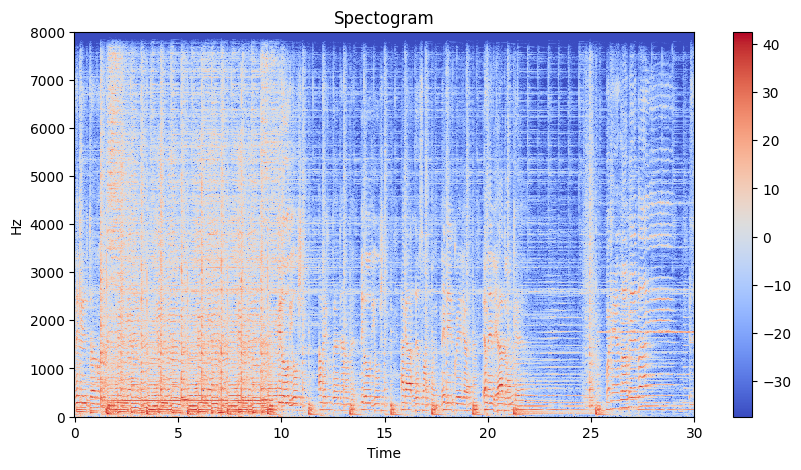

In [ ]:
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize = (10, 5))
librosa.display.specshow(Xdb, sr = rate, x_axis = 'time', y_axis = 'hz')
plt.colorbar()
plt.title("Spectogram")

Text(0.5, 1.0, 'MFCCs')

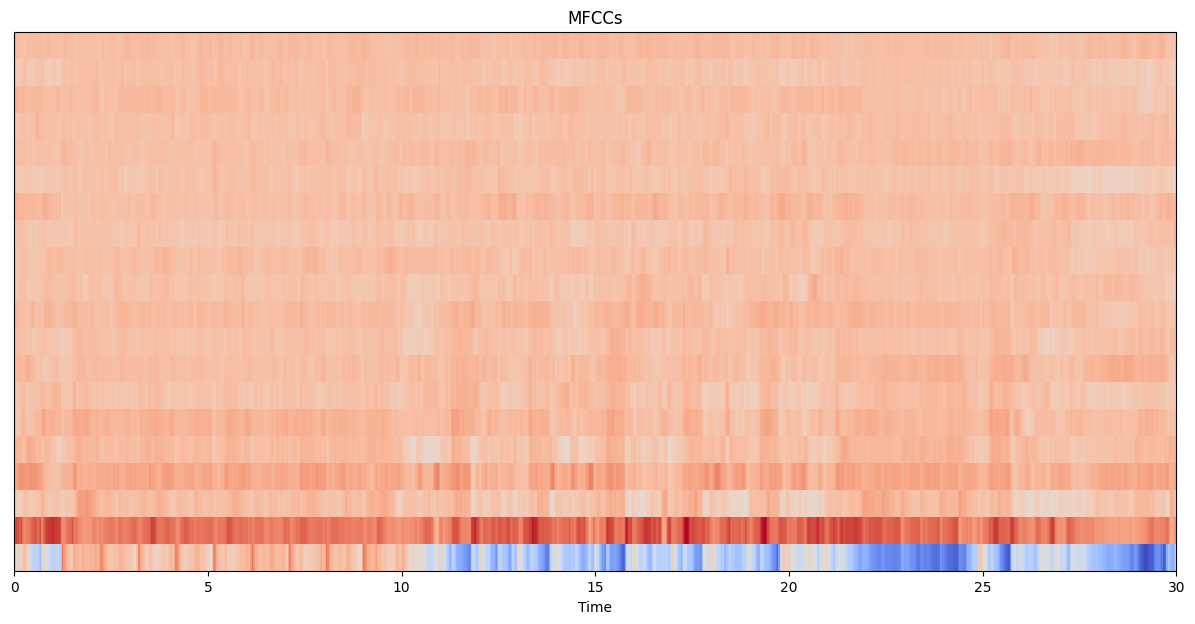

In [ ]:
mfccs = librosa.feature.mfcc(y = audio, sr=rate)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=rate, x_axis='time')
plt.title("MFCCs")

In [ ]:
Audio(audio,rate=16000)

In [ ]:
# Importing Wav2Vec pretrained model

tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:736: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You sho

In [ ]:
# Taking an input value
input_values = tokenizer(audio, return_tensors = "pt").input_values

In [ ]:
# Storing logits (non-normalized prediction values)
logits = model(input_values).logits

In [ ]:
# Storing predicted ids
prediction = torch.argmax(logits, dim = -1)

In [ ]:
# Passing the prediction to the tokenzer decode to get the transcription
transcription = tokenizer.batch_decode(prediction)[0]

In [ ]:
transcription

'GED A CACKER D DED  OF THE DEEP SEA DIE VISINS GOUT OF GARKA  THE SHA DE DIE DAS DA ABEEHE  DIE AE DAS AA BE HE NEW AN EW HE A'

## Whisper api

In [ ]:
# Loading the audio file
audio, rate = librosa.load("/content/rock.00000.wav", sr = 16000)
Audio(audio,rate=16000)

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-large-v2")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v2")
model.config.forced_decoder_ids = None

# load dummy dataset and read audio files
input_features = processor(audio, sampling_rate=rate, return_tensors="pt").input_features

# generate token ids
predicted_ids = model.generate(input_features)
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
print(transcription)

[" Make it a double. Below the ocean, I make my bed down there. Below the ocean, I gotta live somewhere. Maybe the graveyard, yeah maybe I don't care."]


# Fine tuning Wave2Vec2

In [ ]:
from datasets.features.audio import Audio
from datasets import Dataset

In [ ]:
import pandas as pd
df = pd.read_csv("/content/transcripted_v2.csv")
df = df[['filename','text']]
df['filename'] = df['filename'].apply(lambda x: f"/content/gdrive/MyDrive/Music_Data/genres_original/{x}")
df.head()

filename  \
0  /content/gdrive/MyDrive/Music_Data/genres_orig...   
1  /content/gdrive/MyDrive/Music_Data/genres_orig...   
2  /content/gdrive/MyDrive/Music_Data/genres_orig...   
3  /content/gdrive/MyDrive/Music_Data/genres_orig...   
4  /content/gdrive/MyDrive/Music_Data/genres_orig...   

                                                text  
0   White lightning, sweet demons cry The Hell Pa...  
1   Meanwhile, back at the ranch, sitting on my f...  
2   This place is my house I might as well erase ...  
3   until he needs the land I stand on an eye in ...  
4                                                 so

In [ ]:
{"audio": df.filename.tolist(), "text": df.text.tolist()}).cast_column("audio", Audio(sampling_rate=16000)

In [ ]:
from datasets.features.audio import Audio
from datasets import Dataset
df = df[['filename','text']]
df['filename'] = df['filename'].apply(lambda x: f"/content/gdrive/MyDrive/Music_Data/genres_original/{x}")
ds = Dataset.from_dict({"audio": df.filename.tolist(), "text": df.text.tolist()}).cast_column("audio", Audio(sampling_rate=16000))
ds = ds.train_test_split(test_size=0.0001)
ds

DatasetDict({
    train: Dataset({
        features: ['audio', 'text'],
        num_rows: 998
    })
    test: Dataset({
        features: ['audio', 'text'],
        num_rows: 1
    })
})

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

show_random_elements(ds["train"].remove_columns(["audio"]), num_examples=10)

In [ ]:
import re
chars_to_ignore_regex = '[^a-zA-Z ]+'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [ ]:
ds = ds.map(remove_special_characters)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [ ]:
show_random_elements(ds["train"].remove_columns(["audio"]), num_examples=10)

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocabs = ds.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=ds.column_names["train"])
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

{'l': 0,
 'o': 1,
 'x': 2,
 'g': 3,
 'y': 4,
 'w': 5,
 'b': 6,
 'd': 7,
 'i': 8,
 'f': 9,
 'e': 10,
 'p': 11,
 'c': 12,
 's': 13,
 't': 14,
 'r': 15,
 'a': 16,
 'v': 17,
 ' ': 18,
 'j': 19,
 'm': 20,
 'h': 21,
 'k': 22,
 'u': 23,
 'n': 24,
 'z': 25,
 'q': 26}

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

29

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2Processor, Wav2Vec2FeatureExtractor

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
repo_name = "wav2vec2-base-timit-demo-google-colab"

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [ ]:
ds = ds.map(prepare_dataset, remove_columns=ds.column_names["train"], num_proc=4)

0ex [00:00, ?ex/s]

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
).to('cuda')

loading configuration file https://huggingface.co/facebook/wav2vec2-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c7746642f045322fd01afa31271dd490e677ea11999e68660a92619ec7c892b4.ce1f96bfaf3d7475cb8187b9668c7f19437ade45fb9ceb78d2b06a2cec198015
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:356: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Model config Wav2Vec2Config {
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForPreTraining"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastiv

In [ ]:
model.freeze_feature_encoder()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=8,
  evaluation_strategy="no",
  num_train_epochs=5,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=500,
  logging_steps=50,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    train_dataset=ds["train"],
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


In [ ]:
from IPython.display import Audio
import librosa
audio, rate = librosa.load("/content/rock.00000.wav", sr = 16000)
Audio(audio,rate=16000)

In [ ]:
input_values = feature_extractor(audio, return_tensors="pt").input_values.to('cuda')
logits = model(input_values).logits[0]
pred_ids = torch.argmax(logits, axis=-1)

# retrieve word stamps (analogous commands for `output_char_offsets`)
outputs = tokenizer.decode(pred_ids, output_word_offsets=True)
outputs['text']

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


'ijtjwjijdyioyijtcjy[UNK]i moaoapipiamamaioaiamaoamaoaoioimooiaoiiamamocoamaoaomaoaioaoiiimimomiaoio[UNK]iaoamocimaoamimamiaoaimoiaoaoaojijiamamamamoaoaiaoaimoaoaioaoifmomoiaoawaoimimimi[UNK]icdimicitijajijimimim[UNK]irajcyowjwoyjiyijodmyxjwyijxjocjwyjyjyoyymrqyj[UNK]uyicidijijidcdcdijioimjrymj[UNK]jyai[UNK]mqyayayjcmwimrcwxwyjdjcxjipiclriocwcwyjyjojriyjijmjwimjdwijd[UNK]i[UNK]yf[UNK]mdjdwij[UNK]mxowyojyjiiyuyjatoiojmjwidj[UNK]twyjgjmicwyjw aiaoydjdydyujuijujuiujijiuiujyujujyjuyjyjujujmzmyj[UNK]uiumjmjmjujurmrijmi[UNK]mi i moyaoyiymyacmwomjwjmojicmjojwomj[UNK]bowyj[UNK]memjmjmjmjmimdydmymyjyjyjmjyjyjijmijm'

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 998
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 625
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use

OutOfMemoryError: ignored

In [ ]:
input_values = feature_extractor(audio, return_tensors="pt").input_values.to('cuda')
logits = model(input_values).logits[0]
pred_ids = torch.argmax(logits, axis=-1)

# retrieve word stamps (analogous commands for `output_char_offsets`)
outputs = tokenizer.decode(pred_ids, output_word_offsets=True)
outputs['text']

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


'u[UNK]gwc[UNK]uo[UNK]mcgwc[UNK]uvouwcgwubzgbubugwtwzwowkvtowtwowogotwvwowovovwvwowvwvwvwvodtiwvwovovovwvowtwtywtwovwowvwdwowowowowvwowowowovwowowotwtvwvtovgwgwvotgtw[UNK] [UNK]w[UNK]gtgututugvguogokqkonunoununbun[UNK]guwgwgygzk[UNK]vov[UNK]bvnbgw uw[UNK]vzog [UNK] w gzbgz[UNK]b[UNK] vnvb[UNK]tucug[UNK]gwgugugutu[UNK]ugotovnvbnqnkntvuntn[UNK]tn[UNK] gwgwztc ugwbsgu[UNK]gug[UNK]jb[UNK]botutwgwgtvz[UNK]tvo[UNK]bg[UNK]w[UNK] uvuvuvtwugctg[UNK]otucl[UNK] tuougwcucd[UNK]ouc mgwg[UNK]g[UNK]v[UNK]q[UNK]uovov v[UNK]btg cwzoguctc[UNK]x[UNK]ocwzuwbzwtgvgz[UNK]ow c wvukn[UNK]n[UNK]n[UNK]n[UNK]novok[UNK]k q[UNK]k[UNK]obontuknkun[UNK]ntntuonotwobovq ncnzgwzoc c gzvgwgtwzw[UNK]ymvgx [UNK]tw[UNK]wg gcgcegeucecucuctctncncnctcnc[UNK]lt'

# Genre Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import callbacks as cb
import os, json, math, librosa
import librosa.display as dis
import librosa
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input, Activation

import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [ ]:
DATASET_PATH = '/content/gdrive/MyDrive/Music_Data_2/genres_original/'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

num_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 15

samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

mfcc_list = []
label_list = []

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
    if dirpath is not DATASET_PATH:
        semantic_label = dirpath.split("/")[-1]
        print("\nProcessing: {}".format(semantic_label))
        for f in filenames:
            file_path = os.path.join(dirpath, f)
            if file_path != '/content/gdrive/MyDrive/Music_Data_2/genres_original/jazz/jazz.00054.wav':
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                for d in range(num_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        mfcc_list.append(mfcc.tolist())
                        label_list.append(i - 1)

with open(JSON_PATH, "w") as fp:
    json.dump({"mfcc": mfcc_list, "labels": label_list}, fp, indent=4)

print("process finished")



Processing: country

Processing: reggae

Processing: metal

Processing: pop

Processing: rock

Processing: hiphop

Processing: disco

Processing: blues

Processing: jazz

Processing: classical
process finished


In [ ]:
mapping = {}
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
    if dirpath is not DATASET_PATH:
        semantic_label = dirpath.split("/")[-1]
        mapping[i-1]=semantic_label

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

In [ ]:
len(label_list)

14976

In [ ]:
DATA_PATH = "data_10.json"


def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def plot_history(history):
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def predict(model, X, y):
    X = X[np.newaxis, ...]

    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))



In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

## CNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 85, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 43, 6, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 43, 6, 32)         128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 2, 32)         0         
 g2D)                                                            
                                                        

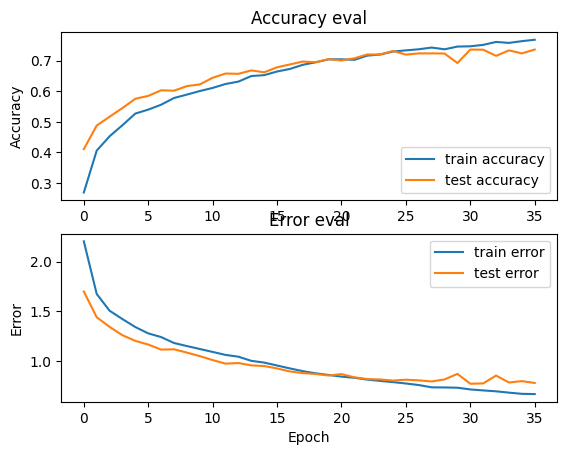

117/117 - 1s - loss: 0.7480 - accuracy: 0.7468 - 953ms/epoch - 8ms/step

Test accuracy: 0.7467948794364929
1/1 [==============================] - 0s 150ms/step
Target: 7, Predicted label: [7]


In [ ]:
def cnn_build_model(input_shape):
    cnn_model = keras.Sequential()

    cnn_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    cnn_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    cnn_model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    cnn_model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    cnn_model.add(keras.layers.Flatten())
    cnn_model.add(keras.layers.Dense(64, activation='relu'))
    cnn_model.add(keras.layers.Dropout(0.2))

    cnn_model.add(keras.layers.Dense(10, activation='softmax'))

    return cnn_model



X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2], 1)
cnn_model = cnn_build_model(input_shape)

optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
cnn_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = cnn_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stopping])
plot_history(history)

test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_to_predict = X_test[100]
y_to_predict = y_test[100]

predict(cnn_model, X_to_predict, y_to_predict)

## GRU

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 87, 32)            4512      
                                                                 
 batch_normalization_3 (Bat  (None, 87, 32)            128       
 chNormalization)                                                
                                                                 
 gru_1 (GRU)                 (None, 87, 32)            6336      
                                                                 
 batch_normalization_4 (Bat  (None, 87, 32)            128       
 chNormalization)                                                
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 batch_normalization_5 (Bat  (None, 32)               

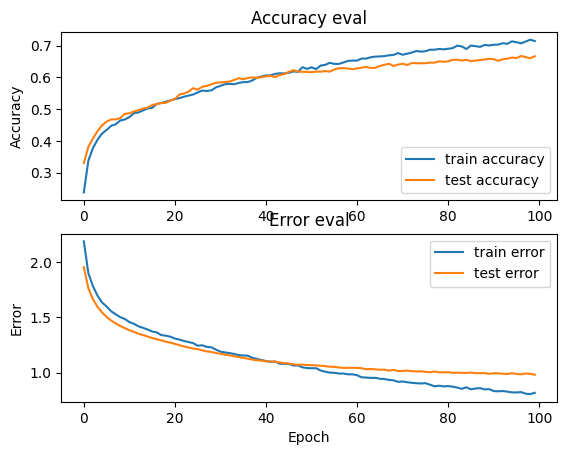

117/117 - 2s - loss: 1.0021 - accuracy: 0.6496 - 2s/epoch - 20ms/step

Test accuracy: 0.6495726704597473
1/1 [==============================] - 1s 996ms/step
Target: 3, Predicted label: [3]


In [ ]:

# Define the function to build the GRU model
def build_gru_model(input_shape):
    gru_model = keras.Sequential()

    gru_model.add(keras.layers.GRU(32, return_sequences=True, input_shape=input_shape))
    gru_model.add(keras.layers.BatchNormalization())

    gru_model.add(keras.layers.GRU(32, return_sequences=True))
    gru_model.add(keras.layers.BatchNormalization())

    gru_model.add(keras.layers.GRU(32))
    gru_model.add(keras.layers.BatchNormalization())

    gru_model.add(keras.layers.Dense(64, activation='relu'))
    gru_model.add(keras.layers.Dropout(0.2))

    gru_model.add(keras.layers.Dense(10, activation='softmax'))

    return gru_model



X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2])

gru_model = build_gru_model(input_shape)

optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
gru_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

gru_model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = gru_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stopping])
plot_history(history)

test_loss, test_acc = gru_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

X_to_predict = X_test[100]
y_to_predict = y_test[100]

predict(gru_model, X_to_predict, y_to_predict)


## TCN

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 87, 32)            1280      
                                                                 
 max_pooling1d (MaxPooling1  (None, 44, 32)            0         
 D)                                                              
                                                                 
 batch_normalization_6 (Bat  (None, 44, 32)            128       
 chNormalization)                                                
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 22, 32)            0         
 g1D)                                                            
                                                      

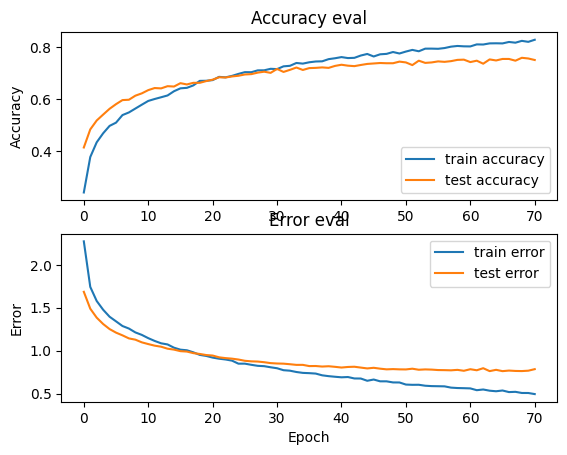

117/117 - 0s - loss: 0.7811 - accuracy: 0.7452 - 377ms/epoch - 3ms/step

Test accuracy: 0.745192289352417
1/1 [==============================] - 0s 150ms/step
Target: 1, Predicted label: [1]


In [ ]:
def tcn_build_model(input_shape):
    tcn_model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='causal'),
        layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='causal'),
        layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(32, kernel_size=2, activation='relu', padding='causal'),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return tcn_model



X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))

tcn_model = tcn_build_model(input_shape)

optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
tcn_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tcn_model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = tcn_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stopping])
plot_history(history)

test_loss, test_acc = tcn_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

X_to_predict = X_test[100]
y_to_predict = y_test[100]

predict(tcn_model, X_to_predict, y_to_predict)


## LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 87, 32)            5888      
                                                                 
 batch_normalization_9 (Bat  (None, 87, 32)            128       
 chNormalization)                                                
                                                                 
 lstm_1 (LSTM)               (None, 87, 32)            8320      
                                                                 
 batch_normalization_10 (Ba  (None, 87, 32)            128       
 tchNormalization)                                               
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 batch_normalization_11 (Ba  (None, 32)               

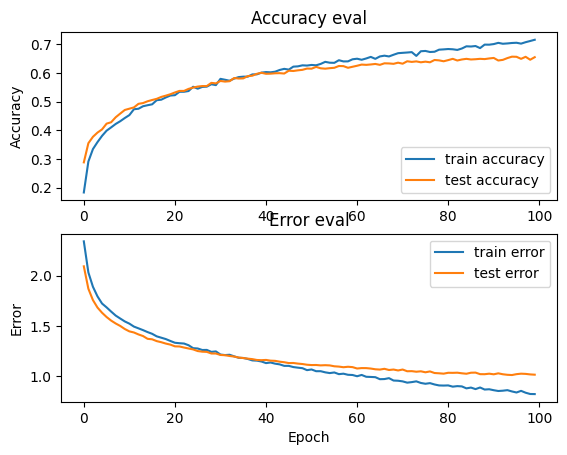

117/117 - 4s - loss: 1.0894 - accuracy: 0.6245 - 4s/epoch - 30ms/step

Test accuracy: 0.624465823173523
1/1 [==============================] - 2s 2s/step
Target: 1, Predicted label: [1]


In [ ]:
def build_lstm_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(32, return_sequences=True),
        layers.BatchNormalization(),

        layers.LSTM(32, return_sequences=True),
        layers.BatchNormalization(),

        layers.LSTM(32),
        layers.BatchNormalization(),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model



input_shape = (X_train.shape[1], X_train.shape[2])  # Adapt based on your input data
num_classes = len(np.unique(y_train))

lstm_model = build_lstm_model(input_shape, num_classes)

optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
lstm_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lstm_model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stopping])
plot_history(history)

test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

X_to_predict = X_test[100]
y_to_predict = y_test[100]
predict(lstm_model, X_to_predict, y_to_predict)


## Ensemble

In [ ]:
models = [lstm_model, cnn_model, tcn_model, gru_model]

ensemble_predictions = []

for model in models:
    predictions = model.predict(X_validation)
    ensemble_predictions.append(predictions)

ensemble_predictions = np.argmax(np.sum(ensemble_predictions, axis=0), axis=1)
ensemble_accuracy = accuracy_score(y_validation, ensemble_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

71/71 [==============================] - 1s 5ms/step
Ensemble Accuracy: 0.8847352024922118


Text(0.5, 1.0, 'Ensemble Confusion Matrix')

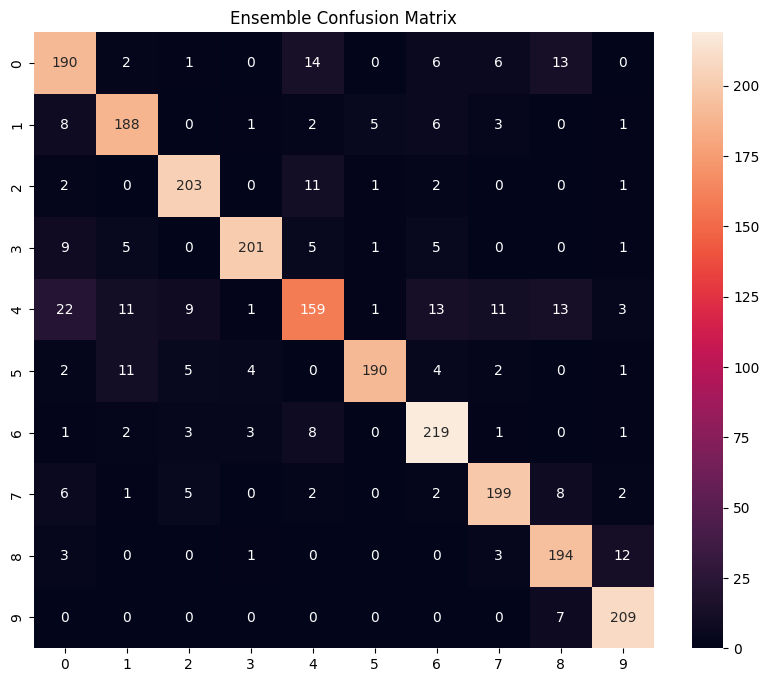

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_validation, ensemble_predictions),annot=True, fmt='d')
plt.title("Ensemble Confusion Matrix")

In [ ]:
final_preds = [mapping[i] for i in ensemble_predictions]

In [ ]:
j = 2
print(y_validation[j])
np.argmax(predictions[j])

9


9

In [ ]:
len(y_validation)

2247

In [ ]:
lstm_model.save("lstm.keras")
cnn_model.save("cnn.keras")
tcn_model.save("tcn.keras")
gru_model.save("gru.keras")

In [ ]:
lstm_model = keras.models.load_model("lstm.keras")
cnn_model = keras.models.load_model("cnn.keras")
tcn_model = keras.models.load_model("tcn.keras")
gru_model = keras.models.load_model("gru.keras")

# Final Pipeline

In [ ]:
!pip install accelerate transformers -q
!pip install -U g4f -q
!pip install googletrans==3.1.0a0 -q --use-deprecated=legacy-resolver

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googletrans 3.1.0a0 requires httpx==0.13.3, but you have httpx 0.25.0 which is incompatible.
ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
duckduckgo-search 3.9.3 requires httpx[brotli,http2,socks]>=0.25.0, but you'll have httpx 0.13.3 which is incompatible.


In [ ]:
import librosa
import torch
from IPython.display import Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, pipeline
import g4f
from IPython.core.display import display
from googletrans import Translator
translator = Translator()

In [ ]:
# load model and processor
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-large-v2")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v2")
whisper_model.config.forced_decoder_ids = None

genre_pipe = pipeline("audio-classification", model="SeyedAli/Musical-genres-Classification-Hubert-V1")
emotion_pipe = pipeline("audio-classification", model="harshit345/xlsr-wav2vec-speech-emotion-recognition")

Some weights of the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at harshit345/xlsr-wav2vec-speech-emotion-recognition and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'projector.bias', 'projector.weight', 'classifier.bias', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def music_analysis(path, language):
  audio, rate = librosa.load(path, sr = 16000)
  display(Audio(audio,rate=16000))

  # Lyrics Generator
  input_features = whisper_processor(audio, sampling_rate=rate, return_tensors="pt").input_features
  predicted_ids = whisper_model.generate(input_features)
  transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)
  print("\n")
  print("Lyrics:- ",transcription)

  # Summarization
  response = g4f.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": f"What is this song talking about:- {transcription[0]}"}],
    stream=True,
    )
  print("\n")
  print("Summary")
  for message in response:
    print(message, flush=True, end='')

  # Genre classification
  print("\n")
  print("Genre Prediction")
  print(genre_pipe(path)[0])

  # Emotion Detection
  print("Emotion Prediction")
  print(emotion_pipe(path)[:3])

  ## Translate
  print("\n")
  print("Translated :-", translator.translate(transcription[0], dest=language).text)

In [ ]:
music_analysis("/content/rock.00000.wav", language="french")



Lyrics:-  [" Make it a double. Below the ocean, I make my bed down there. Below the ocean, I gotta live somewhere. Maybe the graveyard, yeah maybe I don't care."]


Summary
The song is talking about someone who is feeling lost or overwhelmed and is contemplating finding solace or escape in the depths of the ocean. The lyrics suggest that the person is considering making their home underwater, possibly in the graveyard (symbolizing death or isolation), indicating a sense of indifference or apathy towards their current circumstances.

Genre Prediction
{'score': 0.801801860332489, 'label': 'rock'}
Emotion Prediction
[{'score': 0.2177640199661255, 'label': 'happiness'}, {'score': 0.21675199270248413, 'label': 'sadness'}, {'score': 0.19349731504917145, 'label': 'disgust'}]


Translated :- Faites-en un double. Sous l'océan, je fais mon lit là-bas. Sous l'océan, je dois vivre quelque part. Peut-être le cimetière, ouais, peut-être que je m'en fiche.


In [ ]:
!pip install nbconvert

In [ ]:
!jupyter nbconvert --to html /content/MDM_ProjectV3.ipynb

[NbConvertApp] Converting notebook /content/MDM_ProjectV3.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 280, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", l

# Visualization

In [ ]:
!pip install datasets transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.8 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
from datasets.features.audio import Audio
from datasets import Dataset
from tqdm import tqdm
import pandas as pd

In [ ]:
df = pd.read_csv("/content/features_30_sec.csv")
df = df[df['filename']!="jazz.00054.wav"]
df = df[['filename','label']]
df['filename'] = df['filename'].apply(lambda x: f"/content/gdrive/MyDrive/Music_Data/genres_original/{x}")
ds = Dataset.from_dict({"audio": df.filename.tolist(), "label": df.label.tolist()}).cast_column("audio", Audio(sampling_rate=22050))

In [ ]:
emotion_pipe = pipeline("audio-classification", model="harshit345/xlsr-wav2vec-speech-emotion-recognition",device='cuda')

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at harshit345/xlsr-wav2vec-speech-emotion-recognition and are newly initialized: ['projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'classifier.bias', 'projector.bias', 'classifier.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from warnings import filterwarnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
emotions = []
for i in tqdm(range(len(ds))):
  preds = emotion_pipe(ds[i]['audio']['path'])
  emotions.append(max(preds, key=lambda x: x['score'])['label'])

100%|██████████| 999/999 [13:50<00:00,  1.20it/s]


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(predictions, labels)

0.96996996996997

Text(0.5, 1.0, 'Pretrained Confusion Matrix')

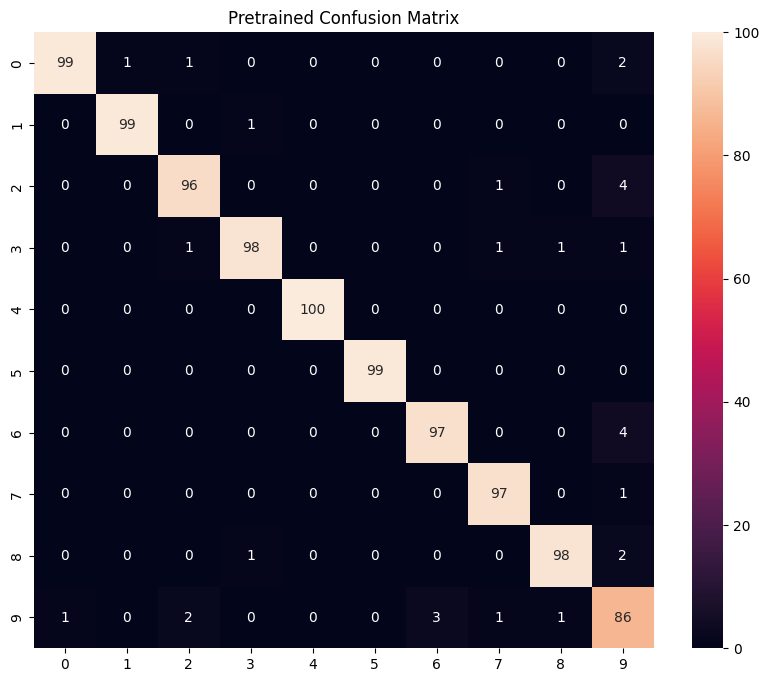

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(predictions, labels),annot=True, fmt='d')
plt.title("Pretrained Confusion Matrix")

In [ ]:
from collections import Counter

# Count the occurrences of each category
category_counts = Counter(emotions)

# Extract category names and their corresponding counts
category_names = list(category_counts.keys())
category_values = list(category_counts.values())


In [ ]:
category_counts

Counter({'fear': 889,
         'anger': 87,
         'sadness': 8,
         'disgust': 14,
         'happiness': 1})

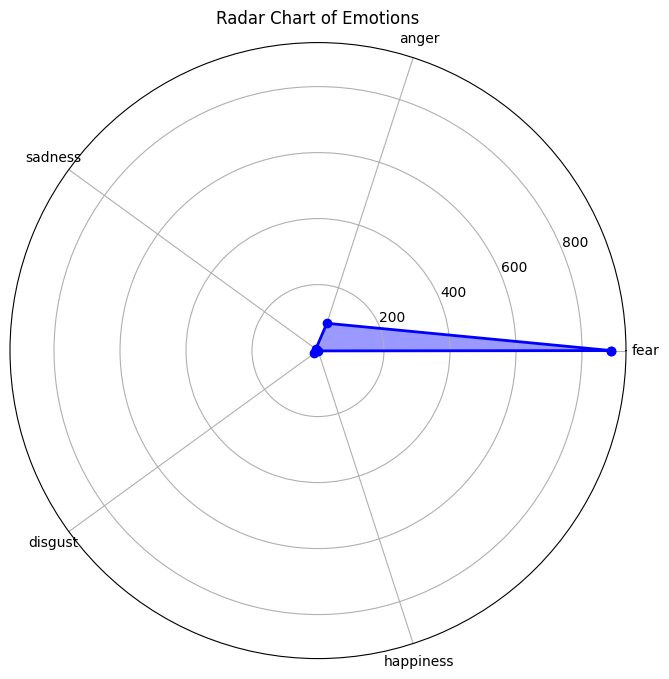

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of categories
num_categories = len(category_names)

# Compute the angle of each axis (divide the circle into equal parts)
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Make the plot circular
category_values += category_values[:1]
angles += angles[:1]

# Plot the radar chart
plt.figure(figsize=(8, 8))
plt.polar(angles, category_values, marker='o', color='b', linewidth=2)
plt.fill(angles, category_values, color='b', alpha=0.4)

# Set category names as labels for each axis
plt.xticks(angles[:-1], category_names)

# Show the radar chart
plt.title("Radar Chart of Emotions")
plt.show()


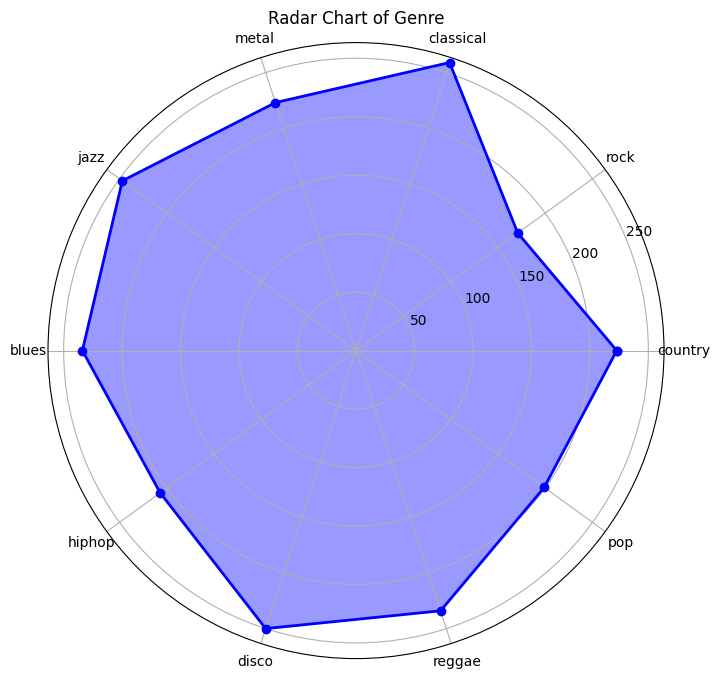

In [ ]:
from collections import Counter

# Count the occurrences of each category
category_counts = Counter(final_preds)

# Extract category names and their corresponding counts
category_names = list(category_counts.keys())
category_values = list(category_counts.values())

import matplotlib.pyplot as plt
import numpy as np

# Number of categories
num_categories = len(category_names)

# Compute the angle of each axis (divide the circle into equal parts)
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Make the plot circular
category_values += category_values[:1]
angles += angles[:1]

# Plot the radar chart
plt.figure(figsize=(8, 8))
plt.polar(angles, category_values, marker='o', color='b', linewidth=2)
plt.fill(angles, category_values, color='b', alpha=0.4)

# Set category names as labels for each axis
plt.xticks(angles[:-1], category_names)

# Show the radar chart
plt.title("Radar Chart of Genre")
plt.show()
